<div style="text-align: justify">
<font size=6><br><h2 align="center">Detección de las conductas distractoras al conducir un automóvil </h2></font>
<font size=5><br>
<h3 align="center">Inteligencia Artificial II</h3></font><font size=5>
<h3 align="center">Proyecto Final</h3></font> 
    
<br/>

<font size=5><h4 align="left">Intregrantes: </h4></font>      
2172016 - Kevin Javier Lozano Galvis<br><br>
2170688 - Brayan Rodolfo Barajas Ochoa<br>

In [1]:
!python -m pip install 'fsspec>=0.3.3'

     |████████████████████████████████| 112kB 6.5MB/s 


In [2]:
import os
import random
import glob
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
import tensorflow as tf
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
from tabulate import tabulate
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras import optimizers

In [3]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=6b45dbddd5c50b42456f3261c35d507c085703b0a97ba7f3dc450ec8d33c1a1d
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevinlozanogalvis","key":"7aa893581a3e3a99473c2eda021232eb"}'}

In [5]:
!ls -lha kaggle.json
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 73 Mar  7 05:16 kaggle.json


In [6]:
!pip install -q kaggle

In [7]:
!kaggle competitions download -c state-farm-distracted-driver-detection -p imgs

100% 4.00G/4.00G [01:11<00:00, 39.6MB/s]
100% 4.00G/4.00G [01:12<00:00, 59.6MB/s]


In [8]:
cd imgs

/content/imgs


In [9]:
!unzip state-farm-distracted-driver-detection.zip -d /content

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/imgs/train/c7/img_56636.jpg  
  inflating: /content/imgs/train/c7/img_56661.jpg  
  inflating: /content/imgs/train/c7/img_56699.jpg  
  inflating: /content/imgs/train/c7/img_56717.jpg  
  inflating: /content/imgs/train/c7/img_56724.jpg  
  inflating: /content/imgs/train/c7/img_56768.jpg  
  inflating: /content/imgs/train/c7/img_56779.jpg  
  inflating: /content/imgs/train/c7/img_56849.jpg  
  inflating: /content/imgs/train/c7/img_56899.jpg  
  inflating: /content/imgs/train/c7/img_56938.jpg  
  inflating: /content/imgs/train/c7/img_5706.jpg  
  inflating: /content/imgs/train/c7/img_57076.jpg  
  inflating: /content/imgs/train/c7/img_57122.jpg  
  inflating: /content/imgs/train/c7/img_57137.jpg  
  inflating: /content/imgs/train/c7/img_5715.jpg  
  inflating: /content/imgs/train/c7/img_57278.jpg  
  inflating: /content/imgs/train/c7/img_57321.jpg  
  inflating: /content/imgs/train/c7/img_57345.jpg  
  inf

In [10]:
%pwd

'/content/imgs'

In [11]:
!rm state-farm-distracted-driver-detection.zip

In [12]:
%ls /content

driver_imgs_list.csv  imgs/  kaggle.json  sample_data/  sample_submission.csv


In [13]:
#@title Clases
categories = [['Class', 'Description'],
         ['c0', 'Safe driving'],
         ['c1', 'Texting (right hand'],
         ['c2', 'Talking on the phone (right hand)'],
         ['c3', 'Texting (left hand)'],
         ['c4', 'Talking on the phone (left hand)'],
         ['c5', 'Operating the radio'],
         ['c6', 'Drinking'],
         ['c7', 'Reaching behind'],
         ['c8', 'Hair and makeup'],
         ['c9', 'Talking to passenger(s)']]
print(tabulate(categories, 
               headers='firstrow', 
               tablefmt='fancy_grid',
               stralign='center',
               floatfmt='.0f'))

╒═════════╤═══════════════════════════════════╕
│  Class  │            Description            │
╞═════════╪═══════════════════════════════════╡
│   c0    │           Safe driving            │
├─────────┼───────────────────────────────────┤
│   c1    │        Texting (right hand        │
├─────────┼───────────────────────────────────┤
│   c2    │ Talking on the phone (right hand) │
├─────────┼───────────────────────────────────┤
│   c3    │        Texting (left hand)        │
├─────────┼───────────────────────────────────┤
│   c4    │ Talking on the phone (left hand)  │
├─────────┼───────────────────────────────────┤
│   c5    │        Operating the radio        │
├─────────┼───────────────────────────────────┤
│   c6    │             Drinking              │
├─────────┼───────────────────────────────────┤
│   c7    │          Reaching behind          │
├─────────┼───────────────────────────────────┤
│   c8    │          Hair and makeup          │
├─────────┼─────────────────────────────

In [14]:
df = pd.read_csv("../driver_imgs_list.csv")
df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

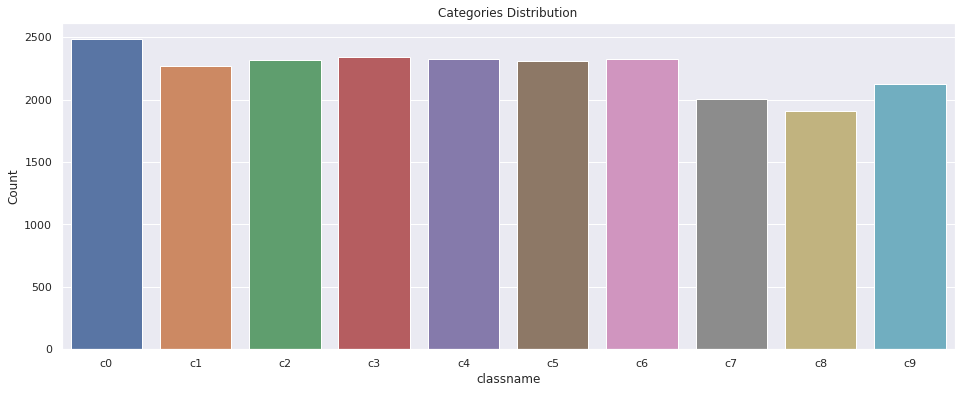

In [15]:
sns.set()
plt.figure(figsize = (16,6))
sns.countplot(x = 'classname',data = df)
plt.title('Categories Distribution'.title())
plt.xlabel('classname')
plt.ylabel('Count')

plt.show()

# Primer Modelo

In [16]:
categor = {'c0': 'Safe driving', 
           'c1': 'Texting - right', 
           'c2': 'Talking on the phone - right', 
           'c3': 'Texting - left', 
           'c4': 'Talking on the phone - left', 
           'c5': 'Operating the radio', 
           'c6': 'Drinking', 
           'c7': 'Reaching behind', 
           'c8': 'Hair and makeup', 
           'c9': 'Talking to passenger'}

In [22]:
# Imágenes del dataset
f, ax = plt.subplots(1,3, figsize = (40,40))
for i in range(3):
    labels = imread("/content/imgs/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        label = i
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(categor['c'+str(i)])
        plt.show

# Algunos ejemplos de como van a quedar las imágenes 
f, ax = plt.subplots(1,3, figsize = (40,40))
for i in range(3):
    labels = imread("/content/imgs/train/c"+str(i)+"/*.jpg")
    for j in range(1):
        img = labels[j]
        img = img[5:,100:-10]
        img = color.rgb2gray(img)
        label = i
        ax[i].axis('off')
        ax[i].imshow(img,cmap='gray')
        ax[i].set_title(categor['c'+str(i)])
        plt.show

Output hidden; open in https://colab.research.google.com to view.

In [23]:
def prepareData(path): 
    imgsList = []
    labels = []
    for directory in sorted(glob.glob(os.path.join(path, '*')), key = lambda k: k.split("/")[-1]):
            for imgs in glob.glob(os.path.join(directory,'*.jpg')):
                img_cv = cv2.imread(imgs)
                img_cv = img_cv[5:,100:-10]
                img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
                img_cv_r = cv2.resize(img_cv,(256,256))
                imgsList.append(img_cv_r)
                labels.append(int(directory.split("/")[-1].replace('c','')))
    
    X_Train, X_Test, Y_Train, Y_Test =  train_test_split(imgsList,labels, test_size = 0.2, random_state=42, shuffle=True)
    Y_Train = tf.keras.utils.to_categorical(Y_Train, num_classes=10)
    Y_Test = tf.keras.utils.to_categorical(Y_Test, num_classes=10)

    return np.array(X_Train), np.array(X_Test), Y_Train, Y_Test

In [24]:
pathTrain_Images = "../imgs/train/"
pathPropagate_Images =  "../imgs/test/"

X_Train, X_Test, Y_Train, Y_Test = prepareData(pathTrain_Images)

print("Tamaño X_Train: {}, Tamaño Y_Train: {}".format(len(X_Train),len(Y_Train)))
print("Tamaño X_Test: {}, Tamaño Y_Test: {}".format(len(X_Test),len(Y_Test)))

Tamaño X_Train: 17939, Tamaño Y_Train: 17939
Tamaño X_Test: 4485, Tamaño Y_Test: 4485


In [32]:
X_Train = np.expand_dims(X_Train, axis=3)
X_Test = np.expand_dims(X_Test, axis=3)

In [33]:
X_Train.shape

(17939, 256, 256, 1, 1)

In [28]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (256 , 256, 1), activation = 'relu',  kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Conv2D(128 , (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64 , activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation = 'softmax')])

ValueError: ignored

In [26]:
model_CNN.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.SGD(lr = 0.001) , metrics = 'accuracy')
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       5

In [ ]:
history = model_CNN.fit(X_Train , Y_Train, epochs = 20, batch_size=64, validation_data=(X_Test, Y_Test)) 

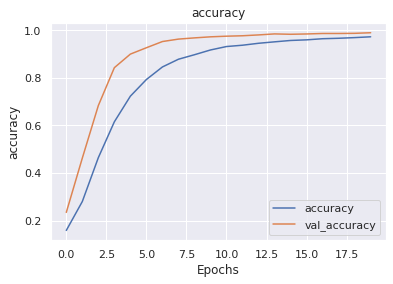

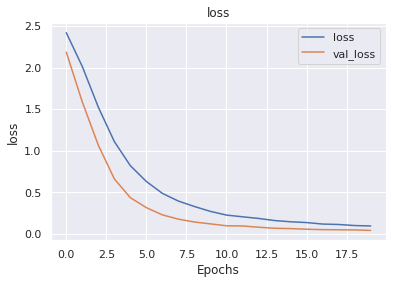

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_CNN.evaluate(X_Test, Y_Test, verbose = 1)

141/141 [==============================] - 2s 11ms/step - loss: 0.0404 - accuracy: 0.9900


Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9


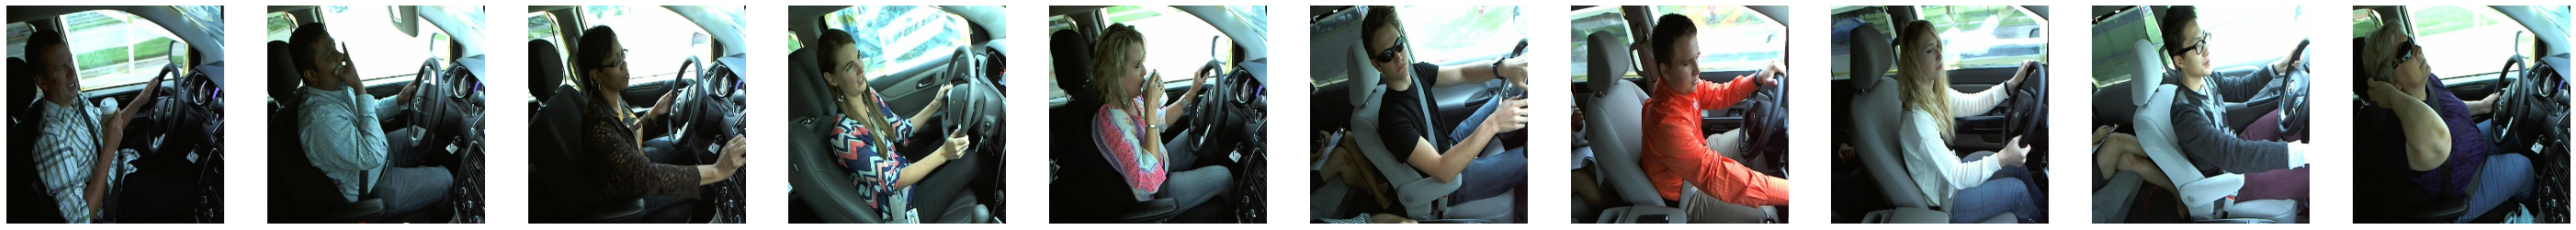

In [ ]:
test_image = []
i = 0
fig, ax = plt.subplots(1, 10, figsize = (50,50))

files = os.listdir('/content/imgs/test/')
nums = np.random.randint(low=1, high=len(files), size=10)
for i in range(10):
    print ('Image number:',i)
    img = cv2.imread('/content/imgs/test/'+files[nums[i]])
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_image.append(img)
    ax[i].imshow(img)
    ax[i].axis('off')
    plt.show

In [ ]:
test = []

for img in test_image:
    test.append(img)

test = np.array(test).reshape(-1,256,256,3)
prediction = model_CNN.predict(test)

In [ ]:
prediction[0]

array([4.7212043e-11, 1.8792467e-05, 1.7572739e-07, 1.6038811e-11,
       5.0527912e-11, 4.8111324e-09, 9.9994552e-01, 2.9893950e-05,
       5.5410637e-06, 1.4753701e-08], dtype=float32)

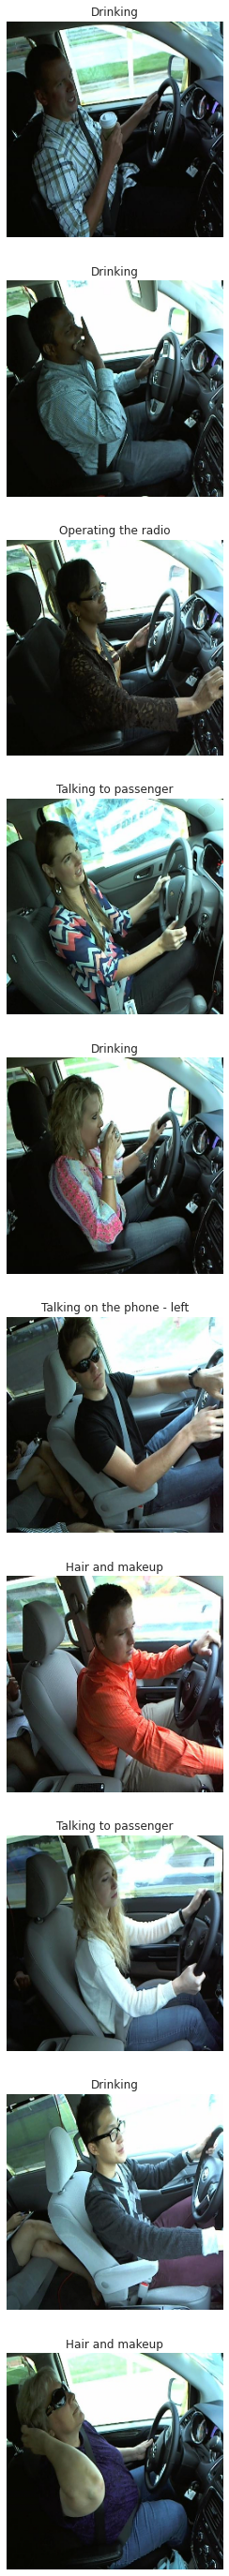

In [ ]:
i = 0
fig, ax = plt.subplots(10, 1, figsize = (50,50 ))

for i in range(10):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'c'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(categor[predicted_class])
    ax[i].axis('off')
    plt.show

In [ ]:
#img = cv2.imread("/content/imgs/test/img_2.jpg")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
#img = cv2.resize(img, (256, 256))

In [ ]:
#test = np.array(img).reshape(-1,256,256,3)

In [ ]:
#test.shape

(1, 256, 256, 3)

In [ ]:
#prediction = model_CNN.predict(test)

In [ ]:
#prediction

array([[2.5627110e-03, 2.0513120e-03, 2.6311863e-02, 8.2961540e-04,
        1.7387031e-02, 1.5823645e-04, 4.9729341e-01, 2.2258221e-04,
        4.4536385e-01, 7.8193163e-03]], dtype=float32)

<function matplotlib.pyplot.show>

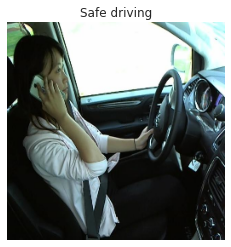

In [ ]:
#plt.imshow(test.squeeze())
#predicted_class = 'c'+str(np.where(prediction == np.amax(prediction))[0][0])
#plt.title(categor[predicted_class])
#plt.axis('off')
#plt.show

# Segundo Modelo

In [ ]:
driver_details = pd.read_csv('/content/driver_imgs_list.csv',na_values='na')
driver_details.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [ ]:
train_image = []
image_label = []

for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/content/imgs/train/c"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[5:,100:-10]
        img = cv2.resize(img,(256,256))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [ ]:
random.shuffle(train_image)

In [ ]:
D = []
for features,labels,drivers in train_image:
    D.append(drivers)

In [ ]:
deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)

In [ ]:
driv_selected = []
import random
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])

In [ ]:
X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18733 3691
18733 3691


In [ ]:
X_train = np.array(X_train).reshape(-1,256,256,3)
X_test = np.array(X_test).reshape(-1,256,256,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print (X_train.shape)

(18733, 256, 256, 3)


In [ ]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (256 , 256 , 3), activation = 'relu',  kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Conv2D(128 , (5,5) , activation = 'relu', kernel_initializer='he_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64 , activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation = 'softmax')])

In [ ]:
model_CNN.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.SGD(lr = 0.001) , metrics = 'accuracy')
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       5

In [ ]:
history = model_CNN.fit(X_train , y_train, epochs = 20, batch_size=64, validation_data=(X_test, y_test)) 

Epoch 1/20
308/308 [==============================] - 19s 61ms/step - loss: 2.7504 - accuracy: 0.1319 - val_loss: 2.3069 - val_accuracy: 0.1051
Epoch 2/20
308/308 [==============================] - 18s 59ms/step - loss: 2.1301 - accuracy: 0.2298 - val_loss: 2.1493 - val_accuracy: 0.2268
Epoch 3/20
308/308 [==============================] - 18s 59ms/step - loss: 1.6828 - accuracy: 0.4170 - val_loss: 1.7538 - val_accuracy: 0.4215
Epoch 4/20
308/308 [==============================] - 18s 59ms/step - loss: 1.1354 - accuracy: 0.6148 - val_loss: 1.6061 - val_accuracy: 0.4800
Epoch 5/20
308/308 [==============================] - 18s 59ms/step - loss: 0.7828 - accuracy: 0.7407 - val_loss: 1.5491 - val_accuracy: 0.5090
Epoch 6/20
308/308 [==============================] - 18s 59ms/step - loss: 0.5737 - accuracy: 0.8146 - val_loss: 1.4750 - val_accuracy: 0.5443
Epoch 7/20
308/308 [==============================] - 18s 59ms/step - loss: 0.4065 - accuracy: 0.8672 - val_loss: 1.5000 - val_accuracy:

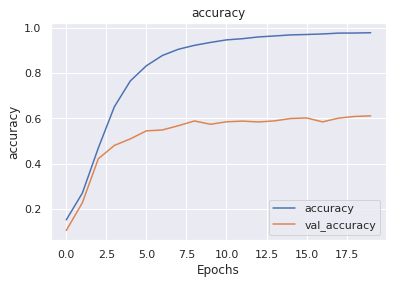

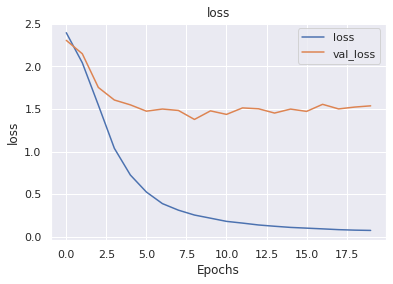

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_CNN.evaluate(X_test, y_test, verbose = 1)

86/86 [==============================] - 1s 11ms/step - loss: 1.5376 - accuracy: 0.6104


# Tercer Modelo

In [ ]:
model_MobileNetV2 =  tf.keras.applications.MobileNetV2(input_shape=(256,256,3), weights='imagenet', include_top=False)
model_MobileNetV2.trainable = False
model_MobileNetV2.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
________________

In [ ]:
dropout = tf.keras.layers.Dropout(0.5)
flatten_layer = tf.keras.layers.Flatten()
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')

In [ ]:
model_cnn_MobileNetV2 = tf.keras.Sequential([
  model_MobileNetV2,
  dropout,
  global_average_layer,
  prediction_layer
])

In [ ]:
model_cnn_MobileNetV2.summary()
print("number of layers to train: ", len( model_cnn_MobileNetV2.trainable_variables))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 1280)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________
number of layers to train:  2


In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model_cnn_MobileNetV2.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_MobileNetV2.fit(X_train, y_train,batch_size=64, epochs=25 ,validation_data=(X_test, y_test))

Epoch 1/25
295/295 [==============================] - 30s 71ms/step - loss: 2.3808 - accuracy: 0.1106 - val_loss: 2.2769 - val_accuracy: 0.1568
Epoch 2/25
295/295 [==============================] - 20s 67ms/step - loss: 2.2808 - accuracy: 0.1384 - val_loss: 2.2404 - val_accuracy: 0.1921
Epoch 3/25
295/295 [==============================] - 20s 67ms/step - loss: 2.2285 - accuracy: 0.1801 - val_loss: 2.2019 - val_accuracy: 0.2118
Epoch 4/25
295/295 [==============================] - 20s 67ms/step - loss: 2.1812 - accuracy: 0.2093 - val_loss: 2.1821 - val_accuracy: 0.2166
Epoch 5/25
295/295 [==============================] - 20s 67ms/step - loss: 2.1397 - accuracy: 0.2484 - val_loss: 2.1515 - val_accuracy: 0.2372
Epoch 6/25
295/295 [==============================] - 20s 67ms/step - loss: 2.1039 - accuracy: 0.2586 - val_loss: 2.1304 - val_accuracy: 0.2381
Epoch 7/25
295/295 [==============================] - 20s 67ms/step - loss: 2.0747 - accuracy: 0.2846 - val_loss: 2.1088 - val_accuracy:

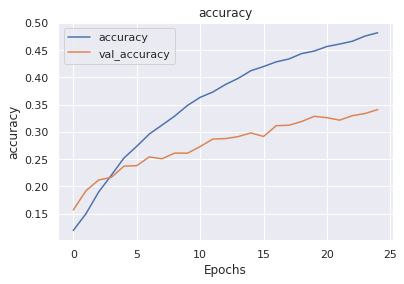

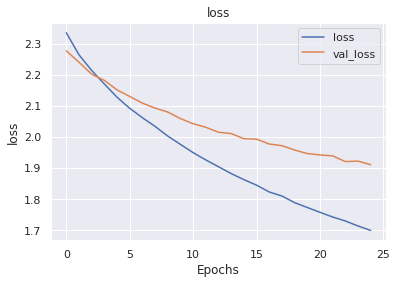

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_cnn_MobileNetV2.evaluate(X_test, y_test, verbose = 1)

111/111 [==============================] - 3s 30ms/step - loss: 1.9111 - accuracy: 0.3410


In [ ]:
model_MobileNetV2.trainable = True
print("Total ayers of Mobilenet: ", len(model_MobileNetV2.layers))
for layer in model_MobileNetV2.layers[50:100]:
  layer.trainable =  False

Total ayers of Mobilenet:  154


In [ ]:
model_cnn_MobileNetV2.summary()
len(model_cnn_MobileNetV2.trainable_variables)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 1280)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 1,923,530
Non-trainable params: 347,264
_________________________________________________________________


107

In [ ]:
opt = tf.keras.optimizers.SGD(0.001/10)
model_cnn_MobileNetV2.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_MobileNetV2.fit(X_train,y_train, epochs=20,verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
590/590 [==============================] - 117s 192ms/step - loss: 2.4314 - accuracy: 0.1443 - val_loss: 2.5274 - val_accuracy: 0.1368
Epoch 2/20
590/590 [==============================] - 113s 191ms/step - loss: 1.9858 - accuracy: 0.3057 - val_loss: 2.2316 - val_accuracy: 0.2505
Epoch 3/20
590/590 [==============================] - 112s 190ms/step - loss: 1.7003 - accuracy: 0.4855 - val_loss: 1.9697 - val_accuracy: 0.3667
Epoch 4/20
590/590 [==============================] - 112s 190ms/step - loss: 1.4578 - accuracy: 0.6202 - val_loss: 1.7761 - val_accuracy: 0.4564
Epoch 5/20
590/590 [==============================] - 112s 190ms/step - loss: 1.2542 - accuracy: 0.7160 - val_loss: 1.6321 - val_accuracy: 0.5188
Epoch 6/20
590/590 [==============================] - 112s 190ms/step - loss: 1.0871 - accuracy: 0.7827 - val_loss: 1.5163 - val_accuracy: 0.5594
Epoch 7/20
590/590 [==============================] - 112s 190ms/step - loss: 0.9418 - accuracy: 0.8336 - val_loss: 1.4190 -

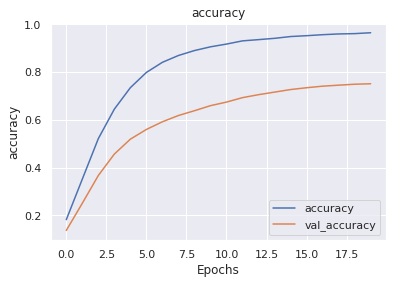

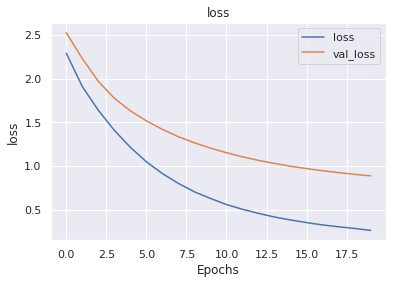

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_cnn_MobileNetV2.evaluate(X_test, y_test, verbose = 1)

111/111 [==============================] - 3s 30ms/step - loss: 0.8865 - accuracy: 0.7506


# Cuarto Modelo

In [ ]:
model_VGG16 =  tf.keras.applications.VGG16( include_top=False,input_shape=(256,256,3), weights='imagenet', pooling=None)
model_VGG16.trainable = True
set_trainable = False

for layer in model_VGG16.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if layer.name == 'block5_conv3':
    set_trainable = True
  if set_trainable: 
    layer.trainable = True
  else:
    layer.trainable = False

model_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
model_cnn_VGG16 = tf.keras.models.Sequential([
    model_VGG16,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32 , activation = 'relu',kernel_initializer='he_uniform', bias_initializer='he_uniform'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_cnn_VGG16.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
flatten_6 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1048608   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 15,765,674
Trainable params: 8,129,386
Non-trainable params: 7,636,288
___________________________________

In [ ]:
learning_rate= 0.0001
opt = tf.keras.optimizers.SGD(learning_rate)
model_cnn_VGG16.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = model_cnn_VGG16.fit(X_train, y_train , epochs=15,verbose=1, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/15
293/293 [==============================] - 56s 188ms/step - loss: 2.7000 - accuracy: 0.1421 - val_loss: 2.1645 - val_accuracy: 0.2132
Epoch 2/15
293/293 [==============================] - 55s 187ms/step - loss: 1.9515 - accuracy: 0.3140 - val_loss: 1.9369 - val_accuracy: 0.3354
Epoch 3/15
293/293 [==============================] - 55s 187ms/step - loss: 1.4974 - accuracy: 0.4961 - val_loss: 1.6869 - val_accuracy: 0.4590
Epoch 4/15
293/293 [==============================] - 55s 187ms/step - loss: 1.0417 - accuracy: 0.6792 - val_loss: 1.4799 - val_accuracy: 0.5473
Epoch 5/15
293/293 [==============================] - 55s 187ms/step - loss: 0.7392 - accuracy: 0.7857 - val_loss: 1.3280 - val_accuracy: 0.5966
Epoch 6/15
293/293 [==============================] - 55s 187ms/step - loss: 0.5490 - accuracy: 0.8521 - val_loss: 1.2169 - val_accuracy: 0.6318
Epoch 7/15
293/293 [==============================] - 55s 187ms/step - loss: 0.4125 - accuracy: 0.8976 - val_loss: 1.1359 - val_ac

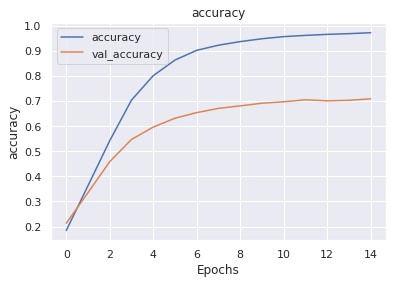

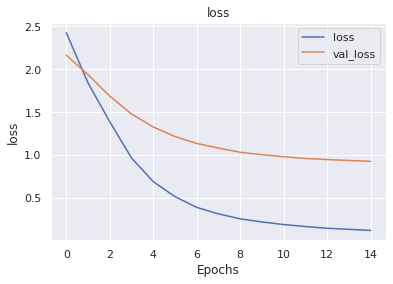

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
validation_loss, validation_acc = model_cnn_VGG16.evaluate(X_test, y_test, verbose = 1)

116/116 [==============================] - 9s 75ms/step - loss: 0.9278 - accuracy: 0.7090


Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9


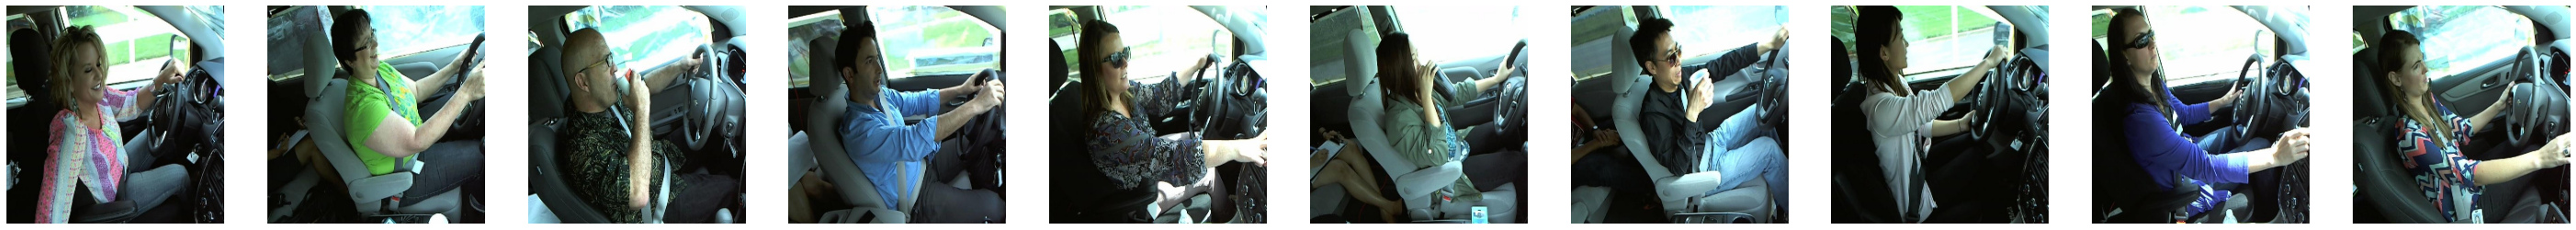

In [ ]:
test_image = []
i = 0
fig, ax = plt.subplots(1, 10, figsize = (50,50))

files = os.listdir('/content/imgs/test/')
nums = np.random.randint(low=1, high=len(files), size=10)
for i in range(10):
    print ('Image number:',i)
    img = cv2.imread('/content/imgs/test/'+files[nums[i]])
    img = cv2.resize(img,(256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_image.append(img)
    ax[i].imshow(img)
    ax[i].axis('off')
    plt.show

In [ ]:
test = []

for img in test_image:
    test.append(img)

test = np.array(test).reshape(-1,256,256,3)
prediction = model_cnn_VGG16.predict(test)

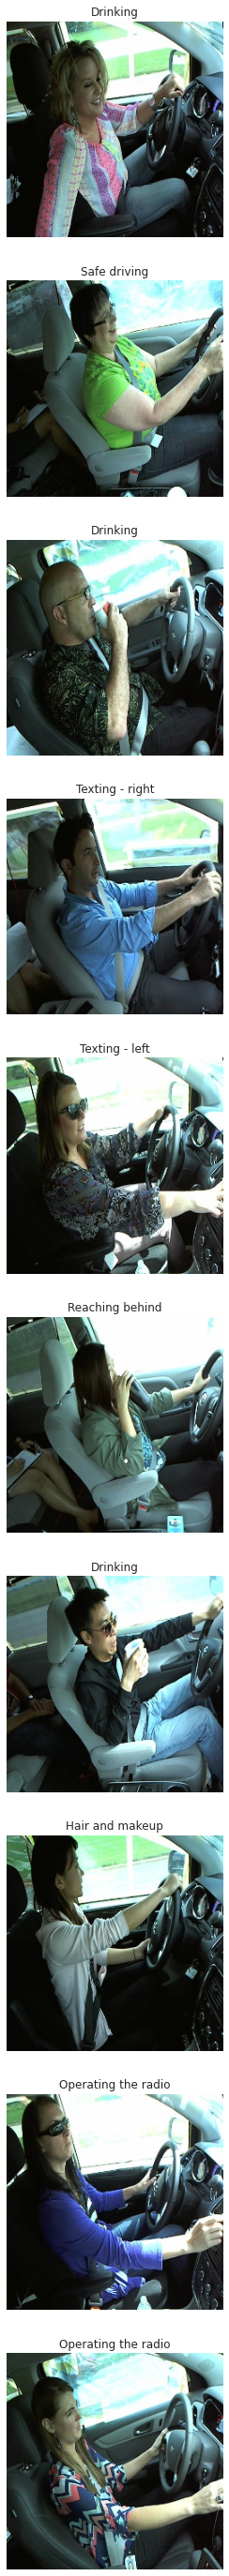

In [ ]:
i = 0
fig, ax = plt.subplots(10, 1, figsize = (50,50 ))

for i in range(10):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'c'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(categor[predicted_class])
    ax[i].axis('off')
    plt.show

Xception

In [ ]:
Xception =  tf.keras.applications.Xception( include_top=False,input_shape=(256,256,3), weights='imagenet', pooling=None)
Xception.trainable = False

Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_21[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
Xception = tf.keras.models.Sequential([
    Xception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128,activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64 , activation = 'relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

Xception.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_71 (Batc (None, 128)               512       
_________________________________________________________________
flatten_12 (Flatten)         (None, 128)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)             

In [ ]:
learning_rate= 0.0001
opt = tf.keras.optimizers.Adam(learning_rate)
Xception.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
history = Xception.fit(X_train, y_train , epochs=30,verbose=1, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/30
147/147 [==============================] - 64s 413ms/step - loss: 3.0693 - accuracy: 0.1098 - val_loss: 2.2738 - val_accuracy: 0.1273
Epoch 2/30
147/147 [==============================] - 60s 406ms/step - loss: 2.7271 - accuracy: 0.1187 - val_loss: 2.2437 - val_accuracy: 0.1666
Epoch 3/30
147/147 [==============================] - 60s 406ms/step - loss: 2.5932 - accuracy: 0.1288 - val_loss: 2.2382 - val_accuracy: 0.1550
Epoch 4/30
147/147 [==============================] - 60s 407ms/step - loss: 2.5082 - accuracy: 0.1372 - val_loss: 2.2350 - val_accuracy: 0.1758
Epoch 5/30
147/147 [==============================] - 60s 406ms/step - loss: 2.4339 - accuracy: 0.1458 - val_loss: 2.2293 - val_accuracy: 0.1840
Epoch 6/30
147/147 [==============================] - 60s 406ms/step - loss: 2.3955 - accuracy: 0.1567 - val_loss: 2.2095 - val_accuracy: 0.1918
Epoch 7/30
147/147 [==============================] - 60s 407ms/step - loss: 2.3441 - accuracy: 0.1601 - val_loss: 2.1991 - val_ac

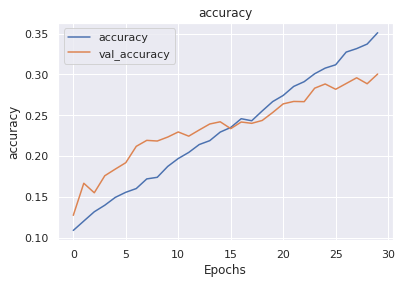

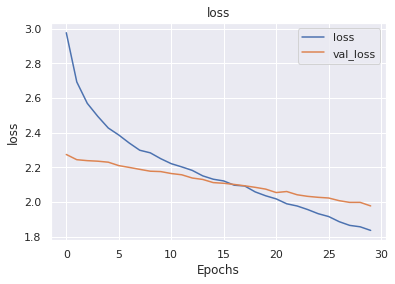

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")